In [35]:
import heapq

In [125]:
import math

class Rect:
    def __init__(self, mins, maxs):
        # `mins` and `maxs` are lists/tuples of length `m`
        self.mins = mins  # Minimum bounds for each dimension
        self.maxs = maxs  # Maximum bounds for each dimension

    def coords(self):
        return self.mins + self.maxs  # Return the min and max for all dimensions

    def area(self):
        # The volume (or hypervolume) of the rectangle in m-dimensional space
        volume = 1
        for i in range(len(self.mins)):
            volume *= (self.maxs[i] - self.mins[i])
        return volume

    def intersect(self, other):
        # Return the intersection of this rectangle with another rectangle
        # In higher dimensions, you intersect each dimension separately
        mins = [max(self.mins[i], other.mins[i]) for i in range(len(self.mins))]
        maxs = [min(self.maxs[i], other.maxs[i]) for i in range(len(self.maxs))]
        
        # If the intersection is invalid (min > max in any dimension), return NullRect
        if any(mins[i] > maxs[i] for i in range(len(mins))):
            return NullRect
        return Rect(mins, maxs)

    def union(self, other):
        # The smallest rectangle that contains both rectangles in all dimensions
        mins = [min(self.mins[i], other.mins[i]) for i in range(len(self.mins))]
        maxs = [max(self.maxs[i], other.maxs[i]) for i in range(len(self.maxs))]
        return Rect(mins, maxs)

    def does_contain(self, other):
        # Check if this rectangle fully contains another
        return all(self.mins[i] <= other.mins[i] and self.maxs[i] >= other.maxs[i] for i in range(len(self.mins)))

    def does_intersect(self, other):
        # Check if this rectangle intersects another
        return self.intersect(other).area() > 0

    def grow(self, amt):
        # Expand the rectangle by a given amount in all dimensions
        return Rect([self.mins[i] - amt for i in range(len(self.mins))],
                    [self.maxs[i] + amt for i in range(len(self.maxs))])
    def distance_to(self, point):
        # For each dimension, compute distance component
        squared_distance = 0
        for i in range(len(self.mins)):
        # Get distance in this dimension - 0 if point is within bounds
            d = max(self.mins[i] - point[i], 0, point[i] - self.maxs[i])
            squared_distance += d ** 2
        return math.sqrt(squared_distance)
    def diagonal(self):
        # Calculate the diagonal length (Euclidean distance across all dimensions)
        return math.sqrt(sum((self.maxs[i] - self.mins[i]) ** 2 for i in range(len(self.mins))))
    def __str__(self):
        return f"Min: {self.mins}, Max: {self.maxs}"
    def __eq__(self,other):
        return self.mins == other.mins and self.maxs == other.maxs
    

# NullRect represents an empty rectangle.
NullRect = Rect([0.0, 0.0] ,[0.0, 0.0])

# Utility function to calculate the union of all rectangles in a list.
def union_all(rects):
    """Return the union of a list of rectangles."""
    if not rects:
        return NullRect

    result = rects[0]
    for rect in rects[1:]:
        result = result.union(rect)
    return result

In [126]:
print(NullRect.distance_to((1,2)))

2.23606797749979


In [127]:
class Entry:
    """
    Represents an entry in an RTreeNode. The format of the entry depends on whether the node is a leaf or not.
    """
    def __init__(self, bounding_box, value):
        """
        Initialize an entry.
        :param bounding_box: The bounding rectangle (`Rect`).
        :param value: For leaf nodes, `value` is an ID (e.g., tuple identifier).
                      For non-leaf nodes, `value` is a child node (`RTreeNode`).
        """
        self.bounding_box = bounding_box  # The bounding rectangle
        self.value = value  # Either an ID (leaf node) or a child node (non-leaf node)
        self.node=node

    def is_leaf_entry(self):
        """
        Check if this entry belongs to a leaf node.
        :return: True if the entry's value is an ID, False if it is a child node.
        """
        return not isinstance(self.value, RTreeNode)

    def __str__(self):
        """
        String representation of the entry.
        """
        entry_type = "Leaf Entry" if self.is_leaf_entry() else "Non-leaf Entry"
        return f"{entry_type}: Bounding Box={self.bounding_box.coords()}, Value={self.value}"


class RTreeNode:
    """
    Represents a node in an R-tree. Contains multiple entries, and each entry may point to child nodes.
    """
    def __init__(self, is_leaf=False, parent_entry=None):
        """
        Initialize an RTreeNode.
        :param is_leaf: Boolean indicating if this is a leaf node.
        :param parent_entry: The entry pointing to this node (None for the root node).
        """
        self.is_leaf = is_leaf  # True if the node is a leaf, False otherwise
        self.entries = []       # List of Entry objects
        self.parent_entry = parent_entry  # Reference to the parent entry (None for the root node)

    def add_entry(self, bounding_box, value):
        """
        Add an entry to the node.
        :param bounding_box: The bounding rectangle (`Rect`).
        :param value: If this is a leaf node, `value` is a tuple identifier (e.g., an ID).
                      If this is a non-leaf node, `value` is a child node (`RTreeNode`).
        """
        entry = Entry(bounding_box, value)  # Create an entry
        
        self.entries.append(entry)
        entry.node=self

        # If the value is a child node, update its parent entry to this entry
        if isinstance(value, RTreeNode):
            value.parent_entry = entry

    def __str__(self):
        """
        String representation of the node.
        """
        node_type = "Leaf" if self.is_leaf else "Non-leaf"
        return f"{node_type} Node: {len(self.entries)} entries"
    def rect(self):
        return union_all([e.bounding_box for e in self.entries])
def union_all_leaf(rects):
    """
    Return the union of rectangles for leaf nodes, extending dimensions when points align.
    """
    """Return the union of a list of rectangles."""
    if not rects:
        return NullRect

    result = rects[0]
    for rect in rects[1:]:
        result = result.union(rect)
    for i in range(len(result.mins)):
        if result.mins[i] == result.maxs[i]:
            result.maxs[i] =result.maxs[i]+0.2
    return result

def leaf(objet):
    if isinstance(objet, RTreeNode):
        return objet.is_leaf
    else:
        return objet.is_leaf_entry()
# Example usage
if __name__ == "__main__":
    # Example bounding boxes
    bbox1 = Rect([0, 0], [1, 1])
    bbox2 = Rect([1, 1], [2, 2])
    bbox3 = Rect([0, 0], [1, 4])
    bbox4 = Rect([0,0],[2,6])
    # Create a root node (non-leaf)
    root = RTreeNode(is_leaf=False)
    node3 = RTreeNode(is_leaf=True)
    node = RTreeNode(is_leaf=False)
    node2 = RTreeNode(is_leaf=True)
    node3.add_entry(bbox4,'ID2')
    node2.add_entry(bbox2,'ID')
    root.add_entry(bbox3,node)
    node.add_entry(bbox1,node2)
    node.add_entry(bbox4,node3)
   
    

    # Print the structure
    print("Root Node:")
    print(root)

    

    print("\nEntries in the node node:")
    for entry in node.entries:
        print(entry)

    print("\nEntries in the leaf node:")
    for entry in node2.entries:
        print(entry)

    # Access the parent entry of the leaf node
    print("\nParent entry of the leaf node:")
    print(node2.parent_entry)
    print(node3.parent_entry)

Root Node:
Non-leaf Node: 1 entries

Entries in the node node:
Non-leaf Entry: Bounding Box=[0, 0, 1, 1], Value=Leaf Node: 1 entries
Non-leaf Entry: Bounding Box=[0, 0, 2, 6], Value=Leaf Node: 1 entries

Entries in the leaf node:
Leaf Entry: Bounding Box=[1, 1, 2, 2], Value=ID

Parent entry of the leaf node:
Non-leaf Entry: Bounding Box=[0, 0, 1, 1], Value=Leaf Node: 1 entries
Non-leaf Entry: Bounding Box=[0, 0, 2, 6], Value=Leaf Node: 1 entries


In [144]:



class RTree:
    def __init__(self, max_entries=4, min_entries=2):
        self.max_entries = max_entries  # Max entries before a split
        self.min_entries = min_entries  # Min entries after a split
        self.root = RTreeNode(is_leaf=True)  # Initialize the root as a leaf node

    def insert(self, bounding_box, value):
        """
        Insert a new entry into the R-tree.
        :param bounding_box: The bounding rectangle for the entry.
        :param value: The value associated with the entry (ID for leaf or child node for non-leaf).
        """
        rect = Rect(bounding_box[0], bounding_box[1])
        leaf = self.choose_leaf(self.root, rect)  # Step 1: Find the appropriate leaf node
        print(leaf)
        # Step 2: Insert the new entry into the leaf node
        leaf.add_entry(rect, value)

        # Step 3: Handle node overflow
        if len(leaf.entries) > self.max_entries:
            self.split_and_propagate(leaf)
        self.adjust_tree(leaf)

    def adjust_tree(self, node):
        """
        Adjust the tree by propagating changes upward, updating bounding boxes and handling splits.
        :param node: The node that was modified (usually the leaf node).
        """
        current_node = node
        while current_node is not None:
            # If the node is the root, stop the adjustment process
            if current_node is self.root:
                break
            
            # Step 1: Get the parent node and the entry pointing to the current node
            parent_entry = current_node.parent_entry # parent entry
            node_entry = parent_entry.node
            
            
            # Step 2: Adjust the bounding box of the parent entry to enclose all rectangles in current node
            
            parent_entry.bounding_box = union_all_leaf([e.bounding_box for e in current_node.entries])
            
            # Step 3: If the parent node exceeds max entries, we need to split it
            if len(node_entry.entries) > self.max_entries:
                self.split_and_propagate(node_entry)

            # Move up to the parent node for the next iteration
            current_node = node_entry

    def choose_leaf(self, node, rect):
        """
        Find the appropriate leaf node for a new entry.
        :param node: The current node to search.
        :param rect: The bounding rectangle of the new entry.
        :return: The leaf node where the entry should be inserted.
        """
        if node.is_leaf:
           
            return node

        # Choose the entry that requires the least enlargement of its bounding box
        best_entry = min(
            node.entries,
            key=lambda e: e.bounding_box.union(rect).area() - e.bounding_box.area()
        )
        return self.choose_leaf(best_entry.value, rect)  # Recurse into the child node

    def split_and_propagate(self, node):
        """
        Handle node splitting and propagate changes upwards.
        :param node: The node to split.
        """
        new_node, new_entry = self.split_node(node)

        # If the node is the root, create a new root
        if node is self.root:
            new_root = RTreeNode(is_leaf=False)
            new_root.add_entry(union_all([e.bounding_box for e in node.entries]), node)
            new_root.add_entry(union_all([e.bounding_box for e in new_node.entries]), new_node)
            self.root = new_root
        else:
            # Add the new entry to the parent node
            
            parent = node.parent_entry
            node_entry = parent.node
            node_entry.add_entry(new_entry.bounding_box, new_entry.value)

            # Propagate split if the parent overflows
            if len(node_entry.entries) > self.max_entries:
                self.split_and_propagate( node_entry)

    def split_node(self, node):
        """
        Split a node into two nodes using the quadratic split algorithm.
        :param node: The node to split.
        :return: A tuple (new_node, new_entry) where new_node is the split-off node and
                new_entry is the entry to be added to the parent.
        """
        entries = node.entries[:]
        group1, group2 = self.quadratic_split(entries)

        # Create a new node for group2 with the same type as the original node
        new_node = RTreeNode(is_leaf=node.is_leaf)
        for entry in group2:
            new_node.add_entry(entry.bounding_box, entry.value)

        # Update the original node with group1
        node.entries = group1

        # Create a new entry for the split-off node

        new_bounding_box = union_all([entry.bounding_box for entry in group2])
        new_entry = Entry(new_bounding_box, new_node)

        return new_node, new_entry


    def quadratic_split(self, entries):
        """
        Quadratic-cost splitting algorithm to divide entries into two groups.
        :param entries: List of entries to split.
        :return: Two groups of entries.
        """
        seed1, seed2 = self.pick_seeds(entries)
        group1 = [seed1]
        group2 = [seed2]
        entries.remove(seed1)
        entries.remove(seed2)

        while entries:
            # If one group needs all remaining entries to satisfy min_entries, assign them directly
            if len(group1) + len(entries) == self.min_entries:
                group1.extend(entries)
                break
            elif len(group2) + len(entries) == self.min_entries:
                group2.extend(entries)
                break

            # Pick the next entry to assign
            entry = self.pick_next(group1, group2, entries)
            bbox1 = union_all([e.bounding_box for e in group1])
            bbox2 = union_all([e.bounding_box for e in group2])

            # Assign to the group with least enlargement; resolve ties by size, then count
            if bbox1.union(entry.bounding_box).area() - bbox1.area() < bbox2.union(entry.bounding_box).area() - bbox2.area():
                group1.append(entry)
            else:
                group2.append(entry)

            entries.remove(entry)

        return group1, group2


    def pick_seeds(self, entries):
        """
        Choose the initial seeds for the quadratic split.
        :param entries: List of entries to split.
        :return: Two entries to initialize the groups.
        """
        max_diff = -float('inf')
        seed1 = seed2 = None
        for i in range(len(entries)):
            for j in range(i + 1, len(entries)):
                area_union = entries[i].bounding_box.union(entries[j].bounding_box).area()
                area_sum = entries[i].bounding_box.area() + entries[j].bounding_box.area()
                diff = area_union - area_sum
                if diff > max_diff:
                    max_diff = diff
                    seed1 = entries[i]
                    seed2 = entries[j]
        #print(seed1)
        #print(seed2)
        return seed1, seed2

    def pick_next(self, group1, group2, entries):
        """
        Choose the next entry to assign during a quadratic split.
        :param group1: First group of entries.
        :param group2: Second group of entries.
        :param entries: Remaining entries to assign.
        :return: The next entry to assign.
        """
        max_diff = -float('inf')
        next_entry = None
        for entry in entries:
            bbox1 = union_all([e.bounding_box for e in group1])
            bbox2 = union_all([e.bounding_box for e in group2])
            diff = abs(
                bbox1.union(entry.bounding_box).area() - bbox1.area() -
                (bbox2.union(entry.bounding_box).area() - bbox2.area())
            )
            if diff > max_diff:
                max_diff = diff
                next_entry = entry
        
        return next_entry
    def delete(self, bounding_box, value):
        """
        Remove an entry with the specified bounding box and value from the R-tree.
        :param bounding_box: The bounding rectangle of the entry to remove.
        :param value: The value associated with the entry to remove.
        """
        rect = Rect(bounding_box[0], bounding_box[1])
        target = Entry(rect,value)
        # Step D1: Find the leaf node containing the entry
        leaf = self.find(self.root, target)
        if not leaf:
            print("Entry not found.")
            return  # Entry not found

        # Step D2: Delete the record
        leaf.entries = [e for e in leaf.entries if not (e.bounding_box == rect and e.value == value)]

        # Step D3: Propagate changes
        self.condense_tree(leaf)

        # Step D4: Shorten tree if necessary
        if len(self.root.entries) == 1 and not self.root.is_leaf:
            self.root = self.root.entries[0].value

    def find_leaf(self, node, target, last_visited=None):
        """
        Find the leaf node containing the entry with the specified bounding box and value.
        :param node: The current node to search.
        :param rect: The bounding rectangle of the entry.
        :param value: The value associated with the entry.
        :param last_visited: The last visited entry at the current node to track progress during backtracking.
        :return: The leaf node containing the entry, or None if not found.
        """
        rect = target.bounding_box
        value = target.value
        
        if node.is_leaf:
            # FL2: Search leaf node for the record
            for entry in node.entries:
                print(entry)

                if entry.bounding_box == rect and entry.value == value:

                    return node

            # If not found, move back up and explore siblings
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)

            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        # FL1: Search subtrees
        found = False  # Track if a match is found
        for entry in node.entries:
            print(entry)
            if last_visited is not None and entry == last_visited:
                # Skip already visited entries
                continue

            if entry.bounding_box.does_intersect(rect):
                result = self.find_leaf(entry.value, target)
                if result:  # Stop search if the entry is found
                    return result
                found = True

        # Move back up and explore siblings if not found
        if not found:
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)


            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        return None
    def find(self, node, target, last_visited=None):
        """
        Find the leaf node containing the entry with the specified bounding box and value.
        :param node: The current node to search.
        :param rect: The bounding rectangle of the entry.
        :param value: The value associated with the entry.
        :param last_visited: The last visited entry at the current node to track progress during backtracking.
        :return: The leaf node containing the entry, or None if not found.
        """
        rect = target.bounding_box
        value = target.value
        
        if node.is_leaf:
            # FL2: Search leaf node for the record
            for entry in node.entries:
        
                if entry.bounding_box == rect and entry.value == value:

                    return node

            # If not found, move back up and explore siblings
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)

            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        # FL1: Search subtrees
        found = False  # Track if a match is found
        for entry in node.entries:
            print(entry)
            if last_visited is not None and entry == last_visited:
                # Skip already visited entries
                continue

            if entry.bounding_box.does_contain(rect):
                result = self.find_leaf(entry.value, target)
                if result:  # Stop search if the entry is found
                    return result
                found = True

        # Move back up and explore siblings if not found
        if not found:
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)


            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        return None

    def explore_remaining_siblings(self, parent_node, target, last_visited):
        """
        Explore remaining sibling subtrees of the current node.
        :param parent_node: The parent node whose entries are being explored.
        :param rect: The bounding rectangle of the entry.
        :param value: The value associated with the entry.
        :param last_visited: The last visited entry in the parent node.
        :return: The leaf node containing the entry, or None if not found.
        """
        last_visited_found = False

        for entry in parent_node.entries:
            if not last_visited_found:
                if entry == last_visited:
                    last_visited_found = True
                continue

            # Explore the next subtree
            result = self.find(entry.value, target)
            if result:
                return result

        # If all siblings are explored, move up again
        if parent_node.parent_entry is not None:
            return self.explore_remaining_siblings(parent_node.parent_entry.node, target, parent_node.parent_entry)

        return None




    def condense_tree(self, node):
        """
        Condense the tree after a deletion, handling underflow and re-inserting orphaned entries.
        :param node: The node from which an entry was deleted.
        """
        Q = []  # Set of eliminated nodes
        current_node = node
        parent_entry = current_node.parent_entry
        while current_node is not None:
            # If the node is underfull, remove it and add its entries to Q
            if len(current_node.entries) < self.min_entries and current_node != self.root:
               
                parent_node = parent_entry.node

                # Remove the entry pointing to the current node
                parent_node.entries = [e for e in parent_node.entries if e.value != current_node]

                # Add the current node's entries to Q
                Q.extend(current_node.entries)
            else:
                # Adjust the bounding box of the parent entry to tightly enclose the current node
                if current_node != self.root:
                    parent_entry.bounding_box = union_all([e.bounding_box for e in current_node.entries])

            # Move up the tree
            current_node = current_node.parent_entry.node if current_node.parent_entry else None

        # Re-insert orphaned entries
        for entry in Q:
            if isinstance(entry.value, RTreeNode):
                self.reinsert_subtree(entry)
            else:
                self.insert((entry.bounding_box.mins,entry.bounding_box.maxs), entry.value)

    def reinsert_subtree(self, entry):
        """
        Reinsert a subtree entry into the R-tree at the appropriate level.
        :param entry: The entry to reinsert.
        """
        node = self.choose_subtree(self.root, entry.bounding_box)
        node.add_entry(entry.bounding_box, entry.value)

        # Handle overflow if necessary
        if len(node.entries) > self.max_entries:
            self.split_and_propagate(node)
    def search(self, entry,value):
        """
        Search the R-tree for all entries whose rectangles overlap the given search rectangle.
        :param search_rect: The search rectangle (instance of Rect).
        :return: A list of qualifying entries.
        """
        rect = Rect(entry, entry)
        target = Entry(rect,value)
        # Step D1: Find the leaf node containing the entry
        leaf = self.find(self.root, target)
        if not leaf:
            print("Entry not found.")
            return  # Entry not found
        else:
            print('True')
    def range_search(self, search_rect):
        """
        Search the R-tree for all entries whose rectangles overlap the given search rectangle.
        :param search_rect: The search rectangle (instance of Rect).
        :return: List of qualifying entries.
        """
        results = []
        self._search_node(self.root, search_rect, results)
        return results

    def _search_node(self, node, search_rect, results):
        """
        Recursively search the R-tree nodes for overlapping rectangles.
        :param node: Current node being searched
        :param search_rect: Search rectangle
        :param results: List to accumulate qualifying entries
        """
        if node.is_leaf:
            # Search leaf node
            for entry in node.entries:
                if search_rect.does_contain(entry.bounding_box):
                    results.append(entry)
        else:
            # Search subtrees
            for entry in node.entries:
                if entry.bounding_box.does_intersect(search_rect):
                    self._search_node(entry.value, search_rect, results)

    def nearest_neighbor(self, query_point):
        """
        Find the nearest neighbor to the query point.
        :param query_point: Tuple (x, y) representing query point
        :return: Tuple (distance, value) of nearest neighbor
        """
        return self._nearest_neighbor_recursive(self.root, query_point)

    def _nearest_neighbor_recursive(self, node, query_point, best=None):
        if node.is_leaf:
            for entry in node.entries:
                #print(entry.bounding_box)
                #print(entry.bounding_box.type)
                dist = entry.bounding_box.distance_to(query_point)
                coords = entry.bounding_box.mins
                if best is None or dist < best[0]:
                    best = (dist, coords, entry.value)
        else:
            priority_queue = []
            for entry in node.entries:
                #print(entry.bounding_box)
                #print(entry.bounding_box.type)
                dist = entry.bounding_box.distance_to(query_point)
                if best is None or dist < best[0]:
                    heapq.heappush(priority_queue, (dist, entry.value))
            
            while priority_queue:
                _, child = heapq.heappop(priority_queue)
                best = self._nearest_neighbor_recursive(child, query_point, best)
        
        return best

    def knn(self, query_point, k):
        """
        Find k nearest neighbors to the query point.
        :param query_point: Tuple (x, y) representing query point
        :param k: Number of nearest neighbors to find
        :return: List of k nearest neighbor values sorted by distance
        """
        best = []
        self._knn_recursive(self.root, query_point, k, best)
        return [(abs(dist), coords, val) for dist, coords, val in sorted(best)]

    def _knn_recursive(self, node, query_point, k, best):
        if node.is_leaf:
            for entry in node.entries:
                #print(entry.bounding_box)
                dist = entry.bounding_box.distance_to(query_point)
                coords = entry.bounding_box.mins
                if len(best) < k:
                     heapq.heappush(best, (-dist, coords, entry.value))
                else:
                    if -dist > best[0][0]:
                        heapq.heapreplace(best, (-dist, coords, entry.value))
        else:
            node_queue = []
            for entry in node.entries:
                dist = entry.bounding_box.distance_to(query_point)
                # Store distance and node together
                node_queue.append((dist, entry.value))
            
            # Sort node_queue by distance (no need for priority queue)
            node_queue.sort(key=lambda x: x[0])
            
            # Process nodes in order of distance
            for dist, child_node in node_queue:
                # Only process this node if it could contain points closer than our current kth best
                if len(best) < k or dist < -best[0][0]:
                    self._knn_recursive(child_node, query_point, k, best)
    def bulk_load(self, points):
            """
            Bulk load the R-tree using the given points.
            Points are tuples representing coordinates in the space.
            """
            # Sort points along the first dimension (STR-like bulk loading)
            sorted_points = sorted(points, key=lambda p: p[0])
        
            # Group points into tiles of size max_entries
            tile_size = self.max_entries
            tiles = [sorted_points[i:i + tile_size] for i in range(0, len(sorted_points), tile_size)]
        
            # Create leaf nodes from the tiles
            leaf_nodes = []
            for tile in tiles:
                leaf_node = RTreeNode(is_leaf=True)
                for point in tile:
                    # Create a bounding box for the point (as a degenerate rectangle)
                    bounding_box = (point, point)
                    leaf_node.add_entry(Rect(bounding_box[0], bounding_box[1]), point)
                leaf_nodes.append(leaf_node)
        
            # Build the tree bottom-up
            while len(leaf_nodes) > 1:
                parents = []
                for i in range(0, len(leaf_nodes), self.max_entries):
                    parent_node = RTreeNode(is_leaf=False)
                    children = leaf_nodes[i:i + self.max_entries]
                    for child in children:
                        parent_node.add_entry(child.rect(), child)
                        child.parent_entry = Entry(child.rect(), child)
                    parents.append(parent_node)
                leaf_nodes = parents
        
            # Set the last remaining node as the root
            self.root = leaf_nodes[0]

In [137]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_rtree(node, ax, level=0, parent_rect=None):
    """
    Recursively plot the RTree structure with rectangles.
    :param node: The current RTree node.
    :param ax: The matplotlib axis on which to plot.
    :param level: The current level in the tree (for indentation).
    :param parent_rect: The rectangle of the parent node to draw a line from.
    """
    if node.is_leaf:
        color = 'skyblue'
    else:
        color = 'lightgreen'

    # Plot each entry as a rectangle
    for entry in node.entries:
        rect = entry.bounding_box
        rect_patch = patches.Rectangle(
            (rect.mins[0], rect.mins[1]), 
            rect.maxs[0] - rect.mins[0], 
            rect.maxs[1] - rect.mins[1], 
            linewidth=2, edgecolor='black', facecolor=color, alpha=0.5
        )
        ax.add_patch(rect_patch)
        
        # Draw a line from the parent node to this node (if there is a parent)
        if parent_rect is not None:
            parent_center = [(parent_rect.mins[0] + parent_rect.maxs[0]) / 2, 
                             (parent_rect.mins[1] + parent_rect.maxs[1]) / 2]
            child_center = [(rect.mins[0] + rect.maxs[0]) / 2, 
                            (rect.mins[1] + rect.maxs[1]) / 2]
            ax.plot([parent_center[0], child_center[0]], 
                    [parent_center[1], child_center[1]], 
                    color='black', lw=1)

        # Recursively plot child nodes (for non-leaf nodes)
        if not entry.is_leaf_entry():
            plot_rtree(entry.value, ax, level + 1, rect)
    
    # Set the plot title and labels
    ax.set_title(f"Level {level} - {'Leaf' if node.is_leaf else 'Non-Leaf'} Node", fontsize=10)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim([0, 15])  # Set appropriate x and y limits based on your data
    ax.set_ylim([0, 15])


def visualize_rtree(rtree):
    """
    Visualize the entire RTree structure.
    :param rtree: The RTree object.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Start plotting from the root node
    plot_rtree(rtree.root, ax)

    plt.show()

In [138]:
def builRtree(rtree,points):
    for point in points:
        
        rtree.insert((point,point),f"ID-{2}")

In [153]:
rtree = RTree(max_entries=4, min_entries=2)
def test_rtree_insertion():
    # Create an RTree with max_entries=4 (forces splits when exceeded)
    
    points = [
        (1, 2),
        (2, 3),
        (3, 4),
        (4, 5),
        (5, 6),
        (6, 7),
        (7, 8),
        (8, 9)
    ]

    rtree.bulk_load(points)
    # Define some rectangles to insert
    #rectangles = [
        #Rect([0, 0], [1, 1]),    # Rect 1
       # Rect([2, 2], [3, 3]),    # Rect 2
        #Rect([4, 4], [5, 5]),    # Rect 3
       # Rect([6, 6], [7, 7]),    # Rect 4 (should fill the node)
        #Rect([8, 8], [9, 9]),    # Rect 5 (should trigger a split)
        #Rect([10, 10], [11, 11]) # Rect 6 (tests further splits)
    #]
    
    # Insert rectangles into the RTree
    #for i, rect in enumerate(rectangles):
       # print(f"Inserting Rect {i + 1}: Min {rect.mins}, Max {rect.maxs}")
       # rtree.insert((rect.mins, rect.maxs), f"ID-{i + 1}")
        #visualize_rtree(rtree)
    
    # Display the structure of the RTree after all insertions
    print("\nFinal RTree Structure:")
    display_rtree(rtree.root)
    #visualize_rtree(rtree)

def display_rtree(node, level=0):
    """
    Recursively display the structure of the RTree.
    :param node: The current RTree node.
    :param level: The current level in the tree (for indentation).
    """
    indent = "  " * level
    node_type = "Leaf" if node.is_leaf else "Non-Leaf"
    print(f"{indent}{node_type} Node with {len(node.entries)} entries:")

    for entry in node.entries:
        print(f"{indent}  Entry - Bounding Box: Min {entry.bounding_box.mins}, Max {entry.bounding_box.maxs}, Value: {entry.value}")
        if not entry.is_leaf_entry():  # If it's a non-leaf entry, recurse into the child node
            display_rtree(entry.value, level + 1)

# Run the test
if __name__ == "__main__":
    test_rtree_insertion()



Final RTree Structure:
Non-Leaf Node with 2 entries:
  Entry - Bounding Box: Min [1, 2], Max [4, 5], Value: Leaf Node: 4 entries
  Leaf Node with 4 entries:
    Entry - Bounding Box: Min (1, 2), Max (1, 2), Value: (1, 2)
    Entry - Bounding Box: Min (2, 3), Max (2, 3), Value: (2, 3)
    Entry - Bounding Box: Min (3, 4), Max (3, 4), Value: (3, 4)
    Entry - Bounding Box: Min (4, 5), Max (4, 5), Value: (4, 5)
  Entry - Bounding Box: Min [5, 6], Max [8, 9], Value: Leaf Node: 4 entries
  Leaf Node with 4 entries:
    Entry - Bounding Box: Min (5, 6), Max (5, 6), Value: (5, 6)
    Entry - Bounding Box: Min (6, 7), Max (6, 7), Value: (6, 7)
    Entry - Bounding Box: Min (7, 8), Max (7, 8), Value: (7, 8)
    Entry - Bounding Box: Min (8, 9), Max (8, 9), Value: (8, 9)


In [151]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_rtree(node, ax, level=0, parent_rect=None):
    """
    Recursively plot the RTree structure with rectangles and points.
    :param node: The current RTree node.
    :param ax: The matplotlib axis on which to plot.
    :param level: The current level in the tree (for indentation).
    :param parent_rect: The rectangle of the parent node to draw a line from.
    """
    if node.is_leaf:
        color = 'skyblue'
    else:
        color = 'lightgreen'
    #rootrect_patch = patches.Rectangle(
     #           (node.mins[0], node.mins[1]), 
      #          rect.maxs[0] - rect.mins[0], 
      #          rect.maxs[1] - rect.mins[1], 
      #          linewidth=2, edgecolor='black', facecolor=color, alpha=0.5
      #      )
    #ax.add_patch(rect_patch)
    # Plot each entry
    for entry in node.entries:
        rect = entry.bounding_box

        # Check if the entry is a point (max == min for all dimensions)
        if all(rect.mins[i] == rect.maxs[i] for i in range(len(rect.mins))):
            # Plot the point
            ax.plot(rect.mins[0], rect.mins[1], 'o', color='red', markersize=6, label='Point' if level == 0 else "")
        else:
            # Plot the rectangle
            rect_patch = patches.Rectangle(
                (rect.mins[0], rect.mins[1]), 
                rect.maxs[0] - rect.mins[0], 
                rect.maxs[1] - rect.mins[1], 
                linewidth=2, edgecolor='black', facecolor=color, alpha=0.5
            )
            ax.add_patch(rect_patch)

        # Draw a line from the parent node to this node (if there is a parent)
        if parent_rect is not None:
            parent_center = [(parent_rect.mins[0] + parent_rect.maxs[0]) / 2, 
                             (parent_rect.mins[1] + parent_rect.maxs[1]) / 2]
            child_center = [(rect.mins[0] + rect.maxs[0]) / 2, 
                            (rect.mins[1] + rect.maxs[1]) / 2]
            ax.plot([parent_center[0], child_center[0]], 
                    [parent_center[1], child_center[1]], 
                    color='black', lw=1)

        # Recursively plot child nodes (for non-leaf nodes)
        if not entry.is_leaf_entry():
            plot_rtree(entry.value, ax, level + 1, rect)

    # Set the plot title and labels
    ax.set_title(f"Level {level} - {'Leaf' if node.is_leaf else 'Non-Leaf'} Node", fontsize=10)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim([0, 15])  # Set appropriate x and y limits based on your data
    ax.set_ylim([0, 15])


def visualize_rtree(rtree):
    """
    Visualize the entire RTree structure.
    :param rtree: The RTree object.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Start plotting from the root node
    plot_rtree(rtree.root, ax)

    # Add a legend for points
    ax.legend(loc="upper right")
    plt.show()


C:\Users\mahah\AppData\Local\Temp\ipykernel_2372\3051786169.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


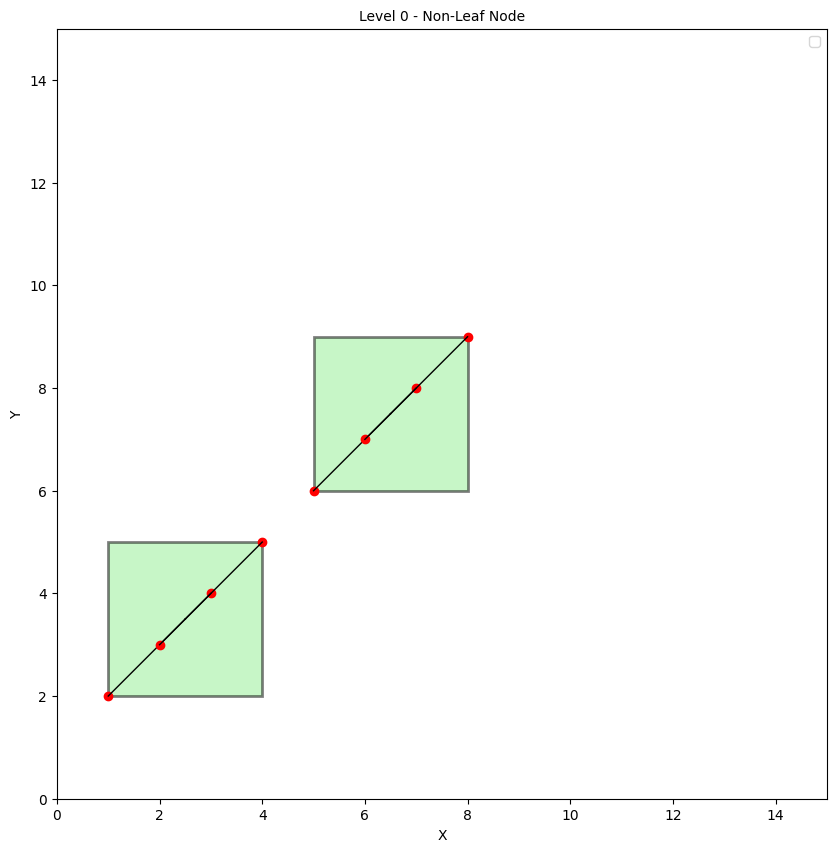

In [155]:
visualize_rtree(rtree)

In [156]:
distance, coordinates, value = rtree.nearest_neighbor((8, 8))
print(f"Distance: {distance}")
print(f"Coordinates: {coordinates}")
print(f"Value: {value}")

Distance: 1.0
Coordinates: (7, 8)
Value: (7, 8)


In [157]:
results = rtree.knn((4, 4), 3)
print(results)
for distance, coords, value in results:
    print(f"Distance: {distance}")
    print(f"Coordinates: {coords}")
    print(f"Value: {value}")

[(2.23606797749979, (2, 3), (2, 3)), (1.0, (3, 4), (3, 4)), (1.0, (4, 5), (4, 5))]
Distance: 2.23606797749979
Coordinates: (2, 3)
Value: (2, 3)
Distance: 1.0
Coordinates: (3, 4)
Value: (3, 4)
Distance: 1.0
Coordinates: (4, 5)
Value: (4, 5)


In [158]:
rtree.search((2,3),(2,3))

Non-leaf Entry: Bounding Box=[1, 2, 4, 5], Value=Leaf Node: 4 entries
Leaf Entry: Bounding Box=(1, 2, 1, 2), Value=(1, 2)
Leaf Entry: Bounding Box=(2, 3, 2, 3), Value=(2, 3)
True


In [159]:
search_area = Rect([0, 0], [10, 10])

# Search tree
results = rtree.range_search(search_area)

# Print results

for entry in results:
    print(entry)

Leaf Entry: Bounding Box=(1, 2, 1, 2), Value=(1, 2)
Leaf Entry: Bounding Box=(2, 3, 2, 3), Value=(2, 3)
Leaf Entry: Bounding Box=(3, 4, 3, 4), Value=(3, 4)
Leaf Entry: Bounding Box=(4, 5, 4, 5), Value=(4, 5)
Leaf Entry: Bounding Box=(5, 6, 5, 6), Value=(5, 6)
Leaf Entry: Bounding Box=(6, 7, 6, 7), Value=(6, 7)
Leaf Entry: Bounding Box=(7, 8, 7, 8), Value=(7, 8)
Leaf Entry: Bounding Box=(8, 9, 8, 9), Value=(8, 9)


In [ ]:
rtree.delete(((2,3), (2,3)),(2,3))

C:\Users\mahah\AppData\Local\Temp\ipykernel_2372\3051786169.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


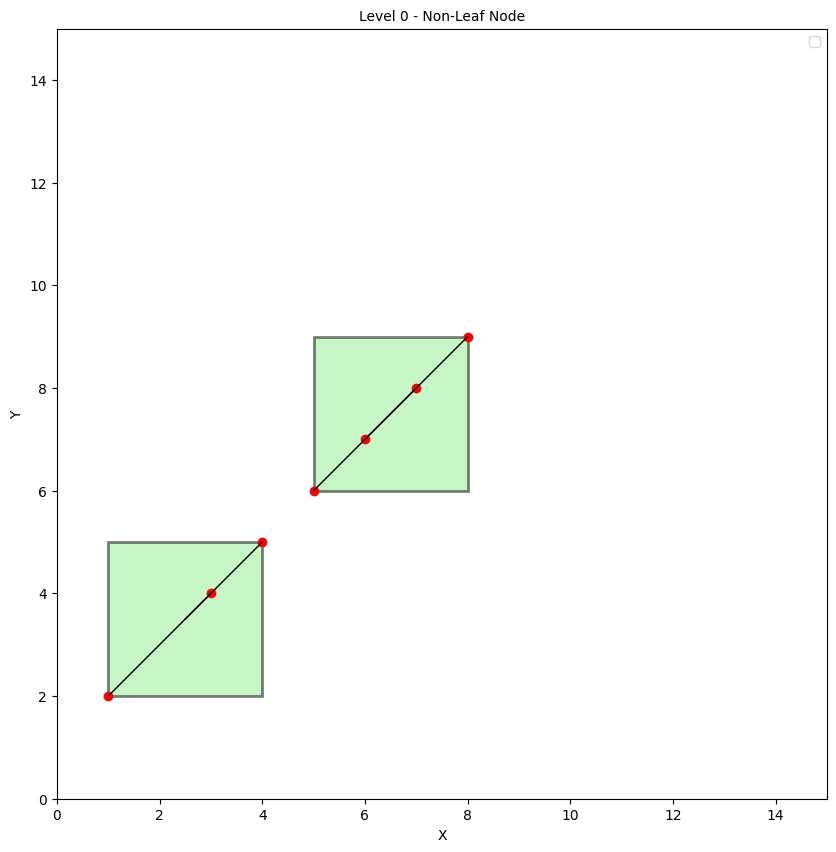

In [30]:
visualize_rtree(rtree)

In [ ]:
rtree.insert(((6,6), (6,6)), f"ID-{7}")
visualize_rtree(rtree)

In [110]:
display_rtree(rtree.root)

Non-Leaf Node with 4 entries:
  Entry - Bounding Box: Min [1, 2], Max [2, 3], Value: Leaf Node: 2 entries
  Leaf Node with 2 entries:
    Entry - Bounding Box: Min (1, 2), Max (1, 2), Value: ID-2
    Entry - Bounding Box: Min (2, 3), Max (2, 3), Value: ID-2
  Entry - Bounding Box: Min [3, 4], Max [4, 5], Value: Leaf Node: 2 entries
  Leaf Node with 2 entries:
    Entry - Bounding Box: Min (3, 4), Max (3, 4), Value: ID-2
    Entry - Bounding Box: Min (4, 5), Max (4, 5), Value: ID-2
  Entry - Bounding Box: Min [5, 6], Max [6, 7], Value: Leaf Node: 3 entries
  Leaf Node with 3 entries:
    Entry - Bounding Box: Min (5, 6), Max (5, 6), Value: ID-2
    Entry - Bounding Box: Min (6, 6), Max (6, 6), Value: ID-7
    Entry - Bounding Box: Min (6, 7), Max (6, 7), Value: ID-2
  Entry - Bounding Box: Min [7, 8], Max [8, 9], Value: Leaf Node: 2 entries
  Leaf Node with 2 entries:
    Entry - Bounding Box: Min (8, 9), Max (8, 9), Value: ID-2
    Entry - Bounding Box: Min (7, 8), Max (7, 8), Value: I

Leaf Node: 3 entries


C:\Users\mahah\AppData\Local\Temp\ipykernel_2444\3051786169.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


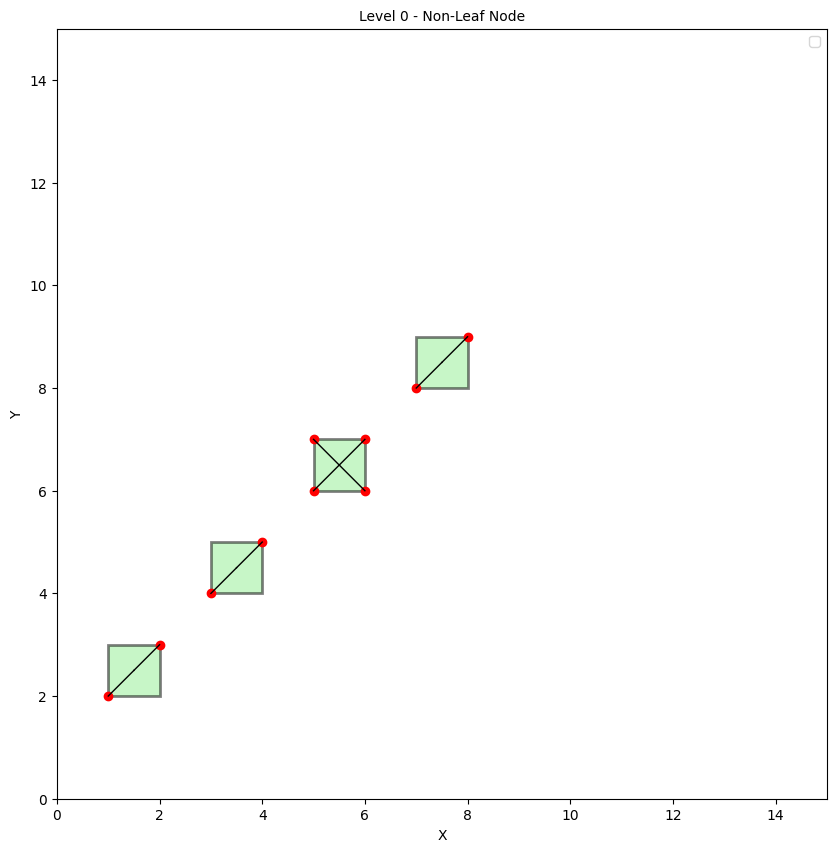

In [120]:
rtree.insert(((5,7), (5,7)), f"ID-{7}")
visualize_rtree(rtree)

In [ ]:
rtree.insert(((5.5,6.5), (5.5,6.5)), f"ID-{7}")
visualize_rtree(rtree)

Leaf Node: 3 entries


C:\Users\mahah\AppData\Local\Temp\ipykernel_2444\3051786169.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


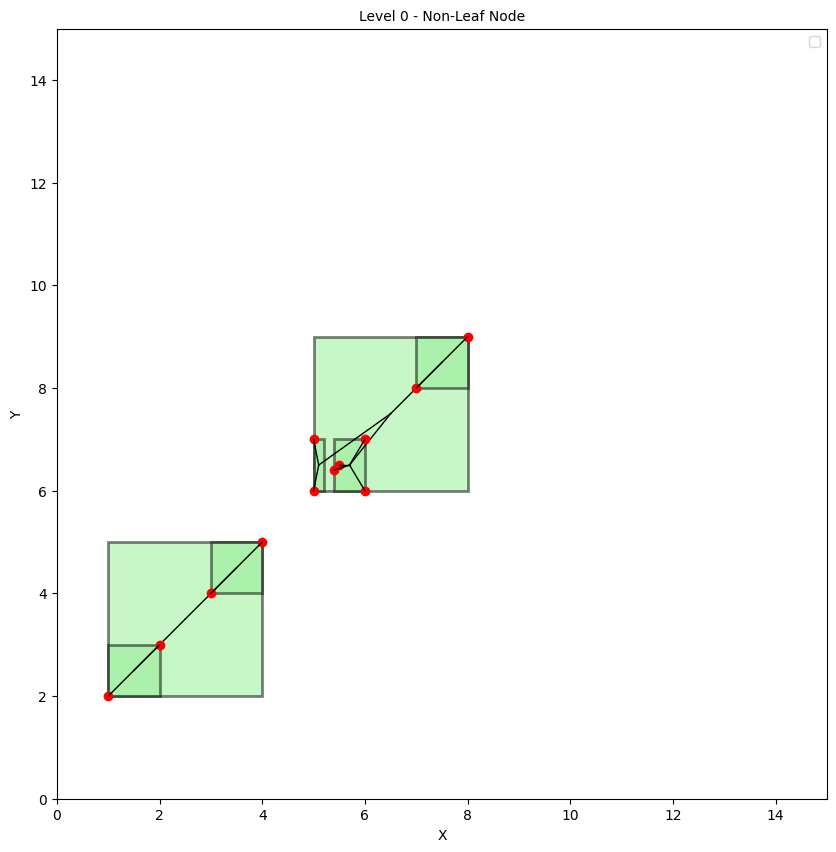

In [122]:
rtree.insert(((5.4,6.4), (5.4,6.4)), f"ID-{7}")
visualize_rtree(rtree)

In [68]:
display_rtree(rtree.root)

Non-Leaf Node with 2 entries:
  Entry - Bounding Box: Min [1, 2], Max [4, 5], Value: Non-leaf Node: 2 entries
  Non-Leaf Node with 2 entries:
    Entry - Bounding Box: Min [1, 2], Max [2, 3], Value: Leaf Node: 2 entries
    Leaf Node with 2 entries:
      Entry - Bounding Box: Min (1, 2), Max (1, 2), Value: ID-2
      Entry - Bounding Box: Min (2, 3), Max (2, 3), Value: ID-2
    Entry - Bounding Box: Min [3, 4], Max [4, 5], Value: Leaf Node: 2 entries
    Leaf Node with 2 entries:
      Entry - Bounding Box: Min (3, 4), Max (3, 4), Value: ID-2
      Entry - Bounding Box: Min (4, 5), Max (4, 5), Value: ID-2
  Entry - Bounding Box: Min [5, 6], Max [8, 9], Value: Non-leaf Node: 3 entries
  Non-Leaf Node with 3 entries:
    Entry - Bounding Box: Min [7, 8], Max [8, 9], Value: Leaf Node: 2 entries
    Leaf Node with 2 entries:
      Entry - Bounding Box: Min (8, 9), Max (8, 9), Value: ID-2
      Entry - Bounding Box: Min (7, 8), Max (7, 8), Value: ID-2
    Entry - Bounding Box: Min [5.5, 6]

In [59]:
point= (8,6)
rect = Rect(point,point)
entry1 = Entry(Rect(point,point),f"ID-{7}")
rtree.insert((rect.mins, rect.maxs), "ID-7")

Leaf Node: 4 entries


In [24]:
print(entry1)



Leaf Entry: Bounding Box=[4, 10, 5, 11], Value=ID-7


In [26]:
rtree.delete((rect.mins, rect.maxs), "ID-7")

Leaf Entry: Bounding Box=[10, 10, 11, 11], Value=ID-6
Leaf Entry: Bounding Box=[8, 8, 9, 9], Value=ID-5
Leaf Entry: Bounding Box=[4, 10, 5, 11], Value=ID-7


In [333]:
print(f"Rect ID in Rectangle: {id(Rect)}")


Rect ID in Rectangle: 2662183408496


In [31]:
display_rtree(rtree.root)

Non-Leaf Node with 3 entries:
  Entry - Bounding Box: Min [0, 0], Max [3, 3], Value: Leaf Node: 2 entries
  Leaf Node with 2 entries:
    Entry - Bounding Box: Min [0, 0], Max [1, 1], Value: ID-1
    Entry - Bounding Box: Min [2, 2], Max [3, 3], Value: ID-2
  Entry - Bounding Box: Min [4, 4], Max [7, 7], Value: Leaf Node: 2 entries
  Leaf Node with 2 entries:
    Entry - Bounding Box: Min [4, 4], Max [5, 5], Value: ID-3
    Entry - Bounding Box: Min [6, 6], Max [7, 7], Value: ID-4
  Entry - Bounding Box: Min [8, 8], Max [11, 11], Value: Leaf Node: 2 entries
  Leaf Node with 2 entries:
    Entry - Bounding Box: Min [10, 10], Max [11, 11], Value: ID-6
    Entry - Bounding Box: Min [8, 8], Max [9, 9], Value: ID-5


In [28]:
rect1 =Rect([0, 0], [1, 1])
rtree.delete((rect1.mins, rect1.maxs), "ID-1")

Leaf Entry: Bounding Box=[0, 0, 1, 1], Value=ID-1
Leaf Node: 2 entries
